In [4]:
pip install ijson

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.8/111.8 kB 2.5 MB/s eta 0:00:00


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
file_path = '/content/drive/MyDrive/dblp.v12.json'

In [7]:
import ijson
import heapq

def get_objects(filename):
    with open(filename, 'r', encoding="utf8") as f:
        objects = ijson.items(f, 'item')
        for obj in objects:
            yield obj

#a function that calculates how many citation an input article has
def number(id):
    num=0
    try:
        num=len(id['references'])
    except:
        num=0
    return num

objects = get_objects(file_path)

#top_items is a list of 10000 articles with most citations
top_items = heapq.nlargest(10000, objects, key=number)

In [8]:
#citation graph
rel_art = []
#the set of first 10000 articles
ids = set(i['id'] for i in top_items)

for i in top_items:
    obj = {}
    obj['id'] = i['id']
    #we are not interested if these articles have cited an article that is not in top_articles
    obj['references'] = [j for j in i['references'] if j in ids]
    rel_art.append(obj)

In [9]:
with open('citation_graph.txt', 'w') as f:
    f.write(f'{rel_art}')

In [10]:
from collections import defaultdict

# Creating a dictionary where the keys are author ids and the values are lists of their articles
articles_by_author = defaultdict(list)
#We iterate over top 10000 articles
for item in top_items:
    #we iterate over authors of these top articles
    for author in item['authors']:
        # Using the 'id' component of the author dictionary as the key
        author_id = author['id']
        articles_by_author[author_id].append(item['id'])

# Converting lists of articles to sets so we can find their intersection
for author_id in articles_by_author:
    articles_by_author[author_id] = set(articles_by_author[author_id])

#function that counts how many elements 2 sets have in common
def common(set1, set2):
    c=list()
    c.append(len(set1.intersection(set2)))
    c=c+list(set1.intersection(set2))
    return c

#function that takes an author from an input and returns dictionary with authors as keys and the number of articles they made with the author from an input as values
def collaborators(aut):
    col = {}
    # Use the 'id' component of the input author dictionary as the key
    aut_id = aut
    for author_id, articles in articles_by_author.items():
        c = common(articles, articles_by_author[aut_id])
        if (c[0] != 0 and articles!=articles_by_author[aut_id]):
            col[author_id] = c
    return col

In [11]:
collaboration_graph=dict()
#we iterate over author ids
for i in articles_by_author.keys():
    #author ids are keys and the output of collaborators function for these ids are values
    collaboration_graph[i]=collaborators(i)

### Functionality 1 - Graph's features

In [12]:
import networkx as nx
import numpy as np
from scipy.stats import scoreatpercentile

"CITATION GRAPH: Unweighted and directed"
"COLLABORATION GRAPH: Weighted and undirected"

citation_graph_nx = nx.DiGraph()

for node in rel_art:
    node_id = node["id"]
    references = node["references"]

    citation_graph_nx.add_node(node_id)

    for reference in references:
        citation_graph_nx.add_edge(node_id, reference)

collaboration_graph_nx = nx.Graph()

for node, edges in collaboration_graph.items():
    for neighbor, weight in edges.items():
        collaboration_graph_nx.add_edge(node, neighbor, weight = weight[0])
        collaboration_graph_nx[node][neighbor]["papers"] = weight[1:]

In [13]:
def graph_features(graph, name):
    number_nodes = graph.number_of_nodes()
    number_edges = graph.number_of_edges()
    density = nx.density(graph)
    if name == "Collaboration":
        degree_distribution = nx.degree_histogram(graph)
    elif name == "Citation":
        degree_distribution_citation_in = np.histogram(list(dict(graph.in_degree()).values()))
        degree_distribution_citation_out = np.histogram(list(dict(graph.out_degree()).values()))
        degree_distribution = [degree_distribution_citation_in, degree_distribution_citation_out]
    avg_degree = np.mean(list(dict(graph.degree()).values()))
    _95thpercentile = np.percentile(list(dict(graph.degree()).values()), 95)
    hubs = [node for node, degree in dict(graph.degree()).items() if degree > _95thpercentile]
    is_dense = density >= 0.5
    return {
        "Number of nodes" : number_nodes,
        "Number of edges" : number_edges,
        "Density" : density,
        "Degree distribution" : degree_distribution,
        "Average degree of the graph" : avg_degree,
        "Graph hubs" : hubs,
        "Is dense?" : is_dense
    }

### Visualization 1 - Visualize graph features

Choose a graph to print (enter 'Citation' or 'Collaboration'): collaboration
+-----------------------------+-----------------+
| Feature                     |           Value |
+=============================+=================+
| Number of nodes             | 14195           |
+-----------------------------+-----------------+
| Number of edges             | 39612           |
+-----------------------------+-----------------+
| Density                     |     0.000393203 |
+-----------------------------+-----------------+
| Average degree of the graph |     5.58112     |
+-----------------------------+-----------------+
| Is dense?                   |     0           |
+-----------------------------+-----------------+


Graph hubs                                                                                                                                                                                                                                                 => [2106222798, 2099

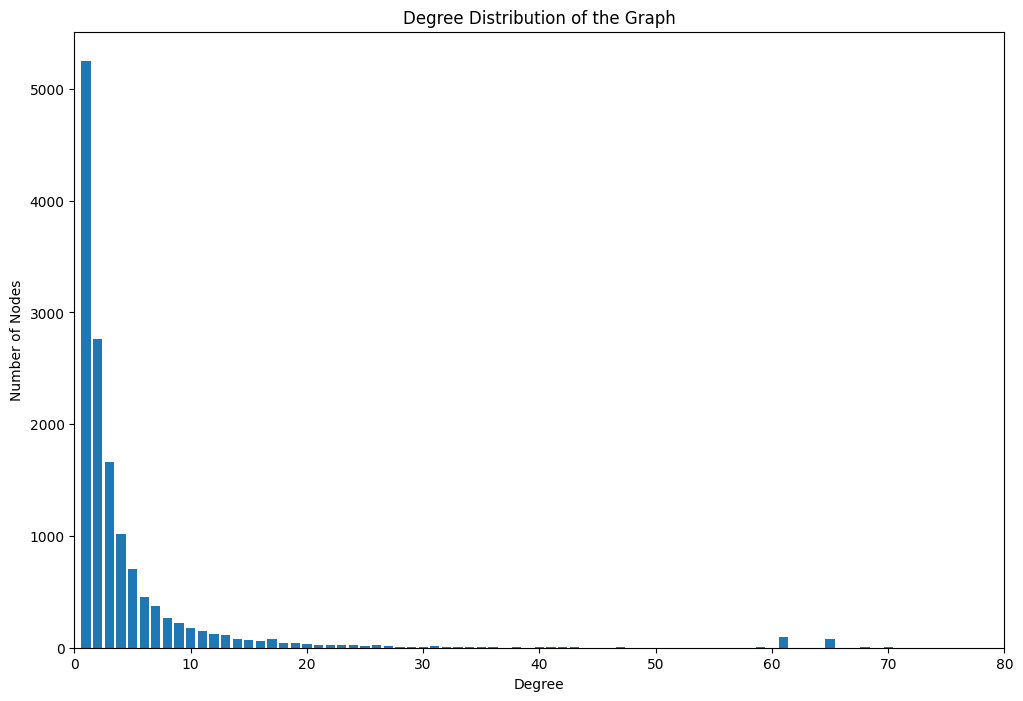

In [14]:
from tabulate import tabulate
import matplotlib.pyplot as plt

# Prompt the user for input
graph_choice = input("Choose a graph to print (enter 'Citation' or 'Collaboration'): ")

# Call the graph_features function on the chosen graph
if graph_choice.lower() == "citation":
    graph_features_dict = graph_features(citation_graph_nx, "Citation")
elif graph_choice.lower() == "collaboration":
    graph_features_dict = graph_features(collaboration_graph_nx, "Collaboration")
else:
    print("Invalid input. Please enter 'Citation' or 'Collaboration'.")

# Print the graph features in a table
print(tabulate([(k, v) for k, v in graph_features_dict.items() if k != "Degree distribution" and k != "Graph hubs"], headers=["Feature", "Value"], tablefmt='grid'))
print("\n")

# Print a table that lists the graph's hubs
for k, v in graph_features_dict.items():
    if k == "Graph hubs":
        print(f'{str(k)[:250]:250} => {str(v)[:250]:250}...]')

# Print A plot depicting the distribution of the citations received by papers
if graph_choice.lower() == "citation":
    for k, v in graph_features_dict.items():
        if k == "Degree distribution":
            degree_distribution_citation_in = v[0]
            plt.figure(figsize=(12, 8))
            plt.bar(degree_distribution_citation_in[1][:-1], degree_distribution_citation_in[0])
            plt.xlabel('In-Degree')
            plt.ylabel('Frequency')
            plt.title('In-Degree Distribution')
            plt.xlim(0, 60)
            plt.show()
            #Print A plot depicting the distribution of the given citations by papers
            degree_distribution_citation_out = v[1]
            plt.figure(figsize=(12, 8))
            plt.bar(degree_distribution_citation_out[1][:-1], degree_distribution_citation_out[0])
            plt.xlabel('Out-Degree')
            plt.ylabel('Frequency')
            plt.title('Out-Degree Distribution')
            plt.xlim(0, 60)
            plt.show()


# Print a plot depicting the number of collaborations of the author
if graph_choice.lower() == "collaboration":
    for k, v in graph_features_dict.items():
        if k == "Degree distribution":
            degrees = list(range(len(v)))
            plt.figure(figsize=(12, 8))
            plt.bar(degrees, v)
            plt.xlabel('Degree')
            plt.ylabel('Number of Nodes')
            plt.title('Degree Distribution of the Graph')
            plt.xlim(0, 80)
            plt.show()

### Comment on the results:

In our query we checked the Collaboration Graph's features:  
We can see that most of the authors doesnt collabirate with more than 10 colleages,  
and even more precisely, the vast majority of writers work alone or with only one other person.

Note: we limited the number of nodes for 'Graph hub' to 20 in oredr to improve the visualization.

### Functionality 2 - Nodes' contribution

In [15]:
def centrality_analysis(graph, node, name):
    betweenness_centrality = nx.betweenness_centrality(graph)[node]
    pagerank_centrality = nx.pagerank(graph)[node]
    closeness_centrality = nx.closeness_centrality(graph)[node]
    degree_centrality = nx.degree_centrality(graph)[node]

    return {
        "Graph Name": name,
        "Betweenness Centrality": betweenness_centrality,
        "PageRank Centrality": pagerank_centrality,
        "Closeness Centrality": closeness_centrality,
        "Degree Centrality": degree_centrality
    }

### Visualization 2 - Visualize the node's contribution

In [16]:
# Prompt the user for input
graph_choice = input("Choose a graph to print (enter 'Citation' or 'Collaboration'): ")
node = int(input("Choose a node to analyze: "))

# Call the graph_features function on the chosen graph
if graph_choice.lower() == "citation":
    graph_centrality_analysis = centrality_analysis(citation_graph_nx, node, "Citation")
elif graph_choice.lower() == "collaboration":
    graph_centrality_analysis = centrality_analysis(collaboration_graph_nx, node, "Collaboration")
else:
    print("Invalid input. Please enter 'Citation' or 'Collaboration'.")

#Print a table containing the node's centrality value based on the four centrality measurements
print(tabulate([(k, v) for k, v in graph_centrality_analysis.items()], headers=["Centrality Measurements", "Value"], tablefmt='grid'))

Choose a graph to print (enter 'Citation' or 'Collaboration'): collaboration
Choose a node to analyze: 2295564484
+---------------------------+------------------------+
| Centrality Measurements   | Value                  |
+===========================+========================+
| Graph Name                | Collaboration          |
+---------------------------+------------------------+
| Betweenness Centrality    | 0.0007964117138711971  |
+---------------------------+------------------------+
| PageRank Centrality       | 0.00030221995199759084 |
+---------------------------+------------------------+
| Closeness Centrality      | 0.06248530109916605    |
+---------------------------+------------------------+
| Degree Centrality         | 0.01747217134000282    |
+---------------------------+------------------------+


### Comment on the results:

In our query we checked the various centrality measurements for paper with ID: 2295564484

### Functionality 3 - Shortest ordered walk

In [17]:
def bfs(graph, start_author, end_author):
    if start_author not in graph or end_author not in graph:
        return "No path", 0
    elif len(list(graph.neighbors(start_author))) == 0:
        return "No path", 0

    visited_authors = set()
    queue = [(start_author, [], [])]
    while queue:
        actual_author, path, papers = queue.pop(0)
        if actual_author not in visited_authors:
            visited_authors.add(actual_author)
            if actual_author == end_author:
                return path, papers
            neighbors = list(graph.neighbors(actual_author))
            if len(neighbors) == 0:
                return "No path", 0
            for neigh in neighbors:
                if neigh not in visited_authors:
                    queue.append((neigh, path + [(actual_author, neigh)], papers + [graph[actual_author][neigh]["papers"][0]]))
    return "No path", 0

In [18]:
def shortest_path_order(graph, start_author, end_author, authors, N):
    graph_degrees = dict(graph.degree())
    sorted_degrees = sorted(graph_degrees, key = graph_degrees.get, reverse = True)[:N]
    top_authors = [author for author in sorted_degrees]
    graph = graph.subgraph(top_authors)

    authors_list = authors.copy()
    n = len(authors)
    general_path = []
    papers_visited = []
    authors = set(authors)
    path, papers = bfs(graph, start_author, authors_list[0])
    papers_visited.append(papers)
    if path == "No path":
        return path, 0
    else:
        authors_path = set([item for tup in path[1 : len(path) - 1] for item in tup])
        if len(authors_path.intersection(authors)) != 0:
            return "Order has not been respected", 0
        else:
            general_path = general_path + path
            authors.discard(authors_list[0])
    for i in range(1, n - 1):
        path, papers = bfs(graph, authors_list[i], authors_list[i + 1])
        papers_visited.append(papers)
        if path == "No path":
            return path, 0
        else:
            authors_path = set([item for tup in path[1 : len(path) - 1] for item in tup])
        if len(authors_path.intersection(authors)) != 0:
            return "Order has not been respected", 0
        else:
            general_path = general_path + path
            authors.discard(authors_list[i])
            authors.discard(authors_list[i + 1])
    path, papers=bfs(graph, authors_list[n - 1], end_author)
    papers_visited.append(papers)
    if path == "No path":
        return path, 0
    else:
        authors_path = set([item for tup in path[1 : len(path) - 1] for item in tup])
        if len(authors_path.intersection(authors)) != 0:
            return "Order has not been respected", 0
        else:
            general_path = general_path + path
            papers_visited.append(papers)
            authors.discard(authors_list[n - 1])
    return general_path, papers_visited

### Visualization 3 - Visualize the shortest-ordered route


In [24]:
start_author = 2168527748
authors_list = [2124189993, 2309719787, 2309719787, 2404816295, 2151804848, 2151804848, 2124189993]
end_author = 1886339625
general_path, papers_visited = shortest_path_order(collaboration_graph_nx, start_author, end_author, authors_list, 25)
for papers in papers_visited:
    print(papers)

[2916780012]
[]
[2916780012]
[2916780012, 2916780012]
[]
[2916780012]
[2916780012]
[2916780012]
[(2168527748, 2124189993), (2309719787, 2404816295), (2404816295, 2124189993), (2124189993, 2151804848), (2151804848, 2124189993), (2124189993, 1886339625)]


In [37]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_shortest_walk_spring(graph, shortest_walk, output_filename='shortest_walk_graph.png'):
    # Create a new graph for visualization
    G = nx.Graph(graph)

    # Extract nodes and edges in the shortest walk
    shortest_walk_edges = [(shortest_walk[i][0], shortest_walk[i][1]) for i in range(len(shortest_walk))]
    shortest_walk_nodes = set([node for edge in shortest_walk_edges for node in edge])

    # Set node colors: red for nodes in the shortest walk, blue for others
    node_colors = ['red' if node in shortest_walk_nodes else 'blue' for node in G.nodes]

    # Set edge colors: red for edges in the shortest walk, light gray for others
    edge_colors = ['red' if edge in shortest_walk_edges else 'lightgray' for edge in G.edges]

    # Draw the graph using a spring layout
    pos = nx.spring_layout(G, seed=42)  # Using a seed for consistent layout
    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color=edge_colors, font_weight='bold', node_size=700, alpha=0.7)

    # Label the edges with the order in the shortest walk
    labels = {(shortest_walk[i][0], shortest_walk[i][1]): f'{i+1}' for i in range(len(shortest_walk))}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='red')

    # Save the plot
    plt.savefig(output_filename, format="PNG", dpi=300)
    plt.show()



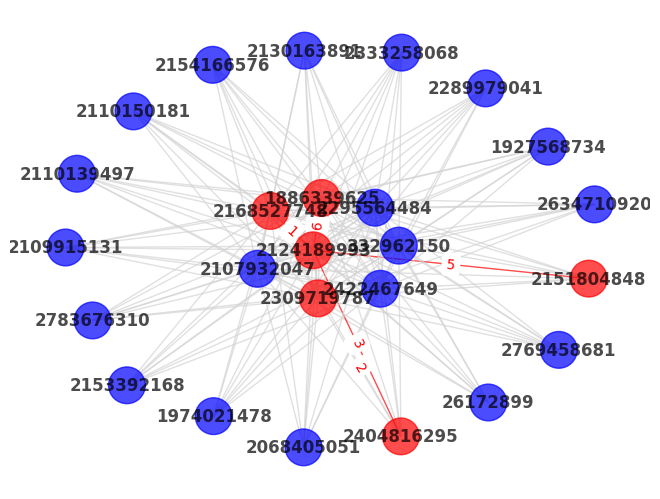

In [38]:
graph_degrees = dict(collaboration_graph_nx.degree())
sorted_degrees = sorted(graph_degrees, key = graph_degrees.get, reverse = True)[:N]
top_authors = [author for author in sorted_degrees]
graph = collaboration_graph_nx.subgraph(top_authors)
plot_shortest_walk_spring(graph, general_path)

### Comment on the results:

In this graph we show the shortest path ordered of the example with the initial author with id 2168527748 and the final author with id 1886339625. The path ordered as we see in the figure must go through the authors with the following ids: 2124189993, 2309719787, 2404816295, 2151804848, 2151804848, 2124189993

## Functionality 4 - Disconnecting Graphs

In [39]:
def disconnegting_graphs(graph, authorA, authorB, N):
    graph_degrees = dict(graph.degree())
    sorted_degrees = sorted(graph_degrees, key = graph_degrees.get, reverse = True)[:N]
    top_authors = [author for author in sorted_degrees]
    graph = graph.subgraph(top_authors)
    modified_graph = graph.copy()
    authorA_nodes_deleted = []
    authorB_nodes_deleted = []
    remEdges = 0
    while len(modified_graph) != 2:
        if remEdges % 2 == 0 and len(list(modified_graph.neighbors(authorA))) > 0:
            node1 = authorA
            neighs_node = modified_graph[node1]
            neighs = sorted(neighs_node, key=lambda x: neighs_node[x]['weight'], reverse=True)
            if authorA in neighs:
                neighs.remove(authorA)
            if authorB in neighs:
                neighs.remove(authorB)
            if len(neighs) == 0:
                remEgdes += 1
                continue
            node2 = neighs[-1]
            modified_graph = nx.contracted_edge(modified_graph, (node1, node2))
            authorA_nodes_deleted.append(node2)
            remEdges += 1
        elif remEdges % 2 == 1 and len(list(modified_graph.neighbors(authorB))) > 0:
            node1 = authorB
            neighs_node = modified_graph[node1]
            neighs = sorted(neighs_node, key=lambda x: neighs_node[x]['weight'], reverse=True)
            if authorA in neighs:
                neighs.remove(authorA)
            if authorB in neighs:
                neighs.remove(authorB)
            if len(neighs) == 0:
                remEdges += 1
                continue
            node2 = neighs[-1]
            modified_graph = nx.contracted_edge(modified_graph, (node1, node2))
            authorB_nodes_deleted.append(node2)
            remEdges += 1

    authorA_nodes_deleted.append(authorA)
    authorB_nodes_deleted.append(authorB)

    subgraph_authorA = nx.subgraph(graph,authorA_nodes_deleted)
    subgraph_authorB = nx.subgraph(graph,authorB_nodes_deleted)
    return len(graph.edges) - len(subgraph_authorA) - len(subgraph_authorB), subgraph_authorA, subgraph_authorB, modified_graph

### Visualization 4 - Visualize the disconnected graph

In [85]:
def visualize_graph(graph, modified_graph, authorA, authorB):
    # Print the number of links that should be disconnected
    num_edges_to_disconnect = len(graph.edges) - len(modified_graph.edges)
    print(f"Number of links to disconnect: {num_edges_to_disconnect}")

    # Plot the original graph
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    pos = nx.circular_layout(graph)
    nx.draw(graph, pos, with_labels=True)
    plt.title('Original Graph')

    # Plot the modified graph after removing links and identify the two nodes
    plt.subplot(1, 2, 2)
    pos_modified = nx.circular_layout(modified_graph)
    nx.draw(modified_graph, pos_modified, with_labels=True, node_color='lightblue', edge_color='gray')
    nx.draw_networkx_nodes(modified_graph, pos_modified, nodelist=[authorA, authorB], node_color='red', node_size=500)
    nx.draw_networkx_labels(modified_graph, pos_modified, labels={authorA: authorA, authorB: authorB}, font_color='black')
    plt.title('Modified Graph after Removing Links')

    # Show the plots
    plt.show()

Number of links to disconnect: 160


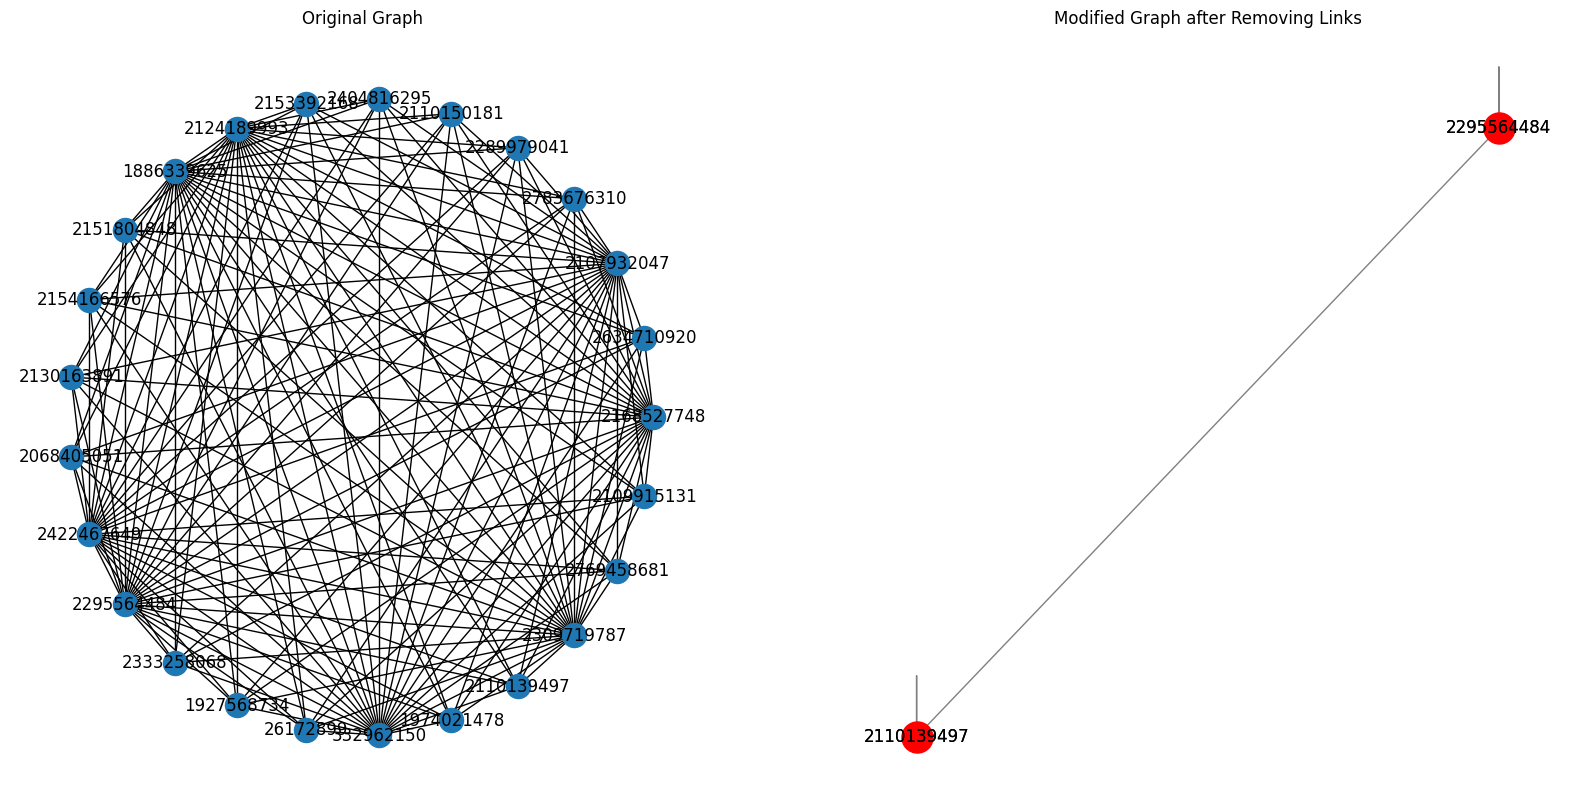

In [86]:
N=50
authorA = 2110139497
authorB= 2295564484
disconnected_links, subgraph_authorA, subgraph_authorB, modified_graph = disconnegting_graphs(graph, authorA, authorB, N)
visualize_graph(graph, modified_graph, authorA, authorB)

### Comment on the results:
As the first result says we removed 160 links so the resulting graph is given by the removal of these links

## Functionality 4 - Disconnecting Graphs

In [71]:
def edge_to_remove(graph):
    G_dict = nx.edge_betweenness_centrality(graph)
    edge = ()

  # extract the edge with highest edge betweenness centrality score
    for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
        edge = key
        break

    return edge

In [72]:
def girvan_newman(graph, N, paper_1, paper_2):
    graph_degrees = dict(graph.degree())
    sorted_degrees = sorted(graph_degrees, key = graph_degrees.get, reverse = True)[:N]
    top_authors = [author for author in sorted_degrees]
    graph = graph.subgraph(top_authors).to_undirected()
    sg = nx.connected_components(graph)
    sg_count = nx.number_connected_components(graph)
    edges_removed = 0
    while sg_count == 1:
        graph.remove_edge(edge_to_remove(graph)[0], edge_to_remove(graph)[1])
        edges_removed += 1
        sg = list(nx.connected_components(graph))
        sg_count = nx.number_connected_components(graph)
    sameCommunity = False
    for community in sg:
        if paper_1 in community and paper_2 in community:
            sameCommunity = True
            break
    return sg, edges_removed, sameCommunity

### Visualization 4 - Visualize the disconnected graph

In [87]:
def plot_graph(graph, title):
    plt.figure()
    plt.title(title)
    pos = nx.circular_layout(graph)
    nx.draw(graph, pos, with_labels=True, font_weight='bold')
    plt.show()

In [88]:
def print_community_table(communities):
    print("Community\tPapers")
    for i, community in enumerate(communities):
        paper_str = ', '.join(str(paper) for paper in community)
        print(f"{i + 1}\t\t{paper_str}")

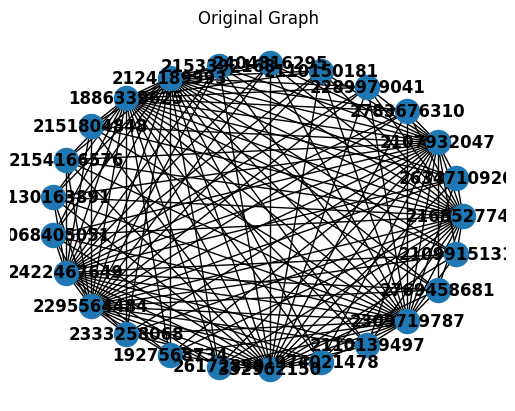

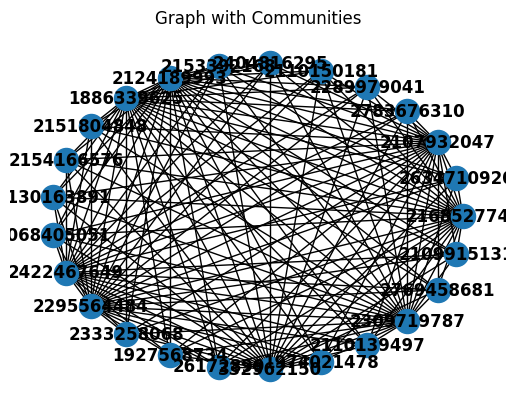

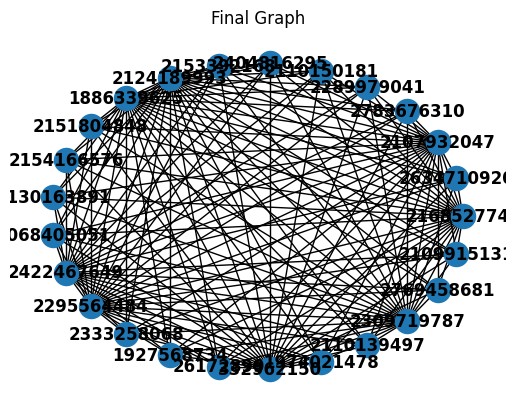


Functionality 5 Report:
Number of links removed: 2

Community	Papers
1		1511198016, 2107460837, 2149202473, 1553243659, 1538284222
2		1642285091

1511198016 and 2149202473 are in the same community: True


In [90]:
strongly_connected_components = nx.strongly_connected_components(citation_graph_nx)
largest_component = max(strongly_connected_components, key=len)
citation_subgraph = citation_graph_nx.subgraph(largest_component)

Paper_1 = 1511198016
Paper_2 = 2149202473
N=1000

# Get the initial graph
initial_graph = graph.copy()

# Visualization 1: Plot the original graph
plot_graph(initial_graph, "Original Graph")

# Functionality 5: Girvan-Newman Algorithm
N = len(graph.nodes())
communities, edges_removed, sameCommunity = girvan_newman(citation_subgraph, N, Paper_1, Paper_2)

# Visualization 2: Plot the graph showing the communities
plot_graph(graph, "Graph with Communities")

# Visualization 3: Plot the final graph
plot_graph(graph, "Final Graph")

# Functionality 5 Report
print("\nFunctionality 5 Report:")
print(f"Number of links removed: {edges_removed}\n")
print_community_table(communities)

# Identify the community/communities of Paper_1 and Paper_2
print(f"\n{Paper_1} and {Paper_2} are in the same community: {sameCommunity}")